In [413]:
import pandas as pd

preproc_file = "processed_data.csv"

df = pd.read_csv(preproc_file, sep=';', engine='python')

therapy_applied = df.query("TherapyApply == 1")
therapy_not_applied = df.query("TherapyApply == 0")



In [414]:
therapy_applied.head()

,CaseID,Gender,Age,Outcome,Vacin,TherapyApply,Результат_F,Результат_D,Severity,Meds,Duration
0,376917,ж,65.0,Выписан,Нет,1,135.9,423.90,Крайне тяжелое,0,67
1,390158,м,73.0,Выписан,Нет,1,1024.5,578.65,Тяжелое,0,45
2,390185,ж,57.0,Умер,Нет,1,606.0,349.60,Крайне тяжелое,0,44
3,390093,ж,66.0,Умер,Нет,1,586.9,486.70,Крайне тяжелое,0,35
4,390165,м,56.0,Выписан,Спутник V,1,1013.0,417.30,Крайне тяжелое,0,41


In [415]:
therapy_not_applied.head()

,CaseID,Gender,Age,Outcome,Vacin,TherapyApply,Результат_F,Результат_D,Severity,Meds,Duration
2451,390819,ж,79.0,Выписан,Нет,0,565.25,853.6,Тяжелое,0,54
2452,390409,ж,49.0,Выписан,Нет,0,387.90,285.9,Тяжелое,0,45
2453,390794,ж,65.0,Выписан,Нет,0,606.00,349.6,Тяжелое,0,40
2454,390448,м,44.0,Выписан,Нет,0,1082.00,320.6,Среднетяжелое,0,35
2455,390760,ж,69.0,Выписан,Нет,0,586.90,486.7,Тяжелое,0,29


In [416]:
therapy_applied_men = therapy_applied.query("Gender == 'м'")
therapy_applied_women = therapy_applied.query("Gender == 'ж'")

therapy_not_applied_men = therapy_not_applied.query("Gender == 'м'")
therapy_not_applied_women = therapy_not_applied.query("Gender == 'ж'")



In [417]:
therapy_applied_men.head()

,CaseID,Gender,Age,Outcome,Vacin,TherapyApply,Результат_F,Результат_D,Severity,Meds,Duration
1,390158,м,73.0,Выписан,Нет,1,1024.5,578.65,Тяжелое,0,45
4,390165,м,56.0,Выписан,Спутник V,1,1013.0,417.30,Крайне тяжелое,0,41
5,390089,м,63.0,Умер,Нет,1,1013.0,417.30,Тяжелое,0,23
6,390142,м,56.0,Выписан,Нет,1,1013.0,417.30,Тяжелое,0,40
8,390164,м,42.0,Выписан,Нет,1,1082.0,320.60,Крайне тяжелое,0,26


In [418]:

print(f"Men applied therapy {therapy_applied_men.shape}")
print(f"Women applied therapy {therapy_applied_women.shape}")
print(f"Men not applied therapy {therapy_not_applied_men.shape}")
print(f"Women not applied therapy {therapy_not_applied_women.shape}")


Men applied therapy (1059, 11)
Women applied therapy (1392, 11)
Men not applied therapy (2343, 11)
Women not applied therapy (3704, 11)


In [419]:
therapy_applied_men.loc[therapy_applied_men['Результат_F'] > 3000, 'Результат_F'] = 3200
therapy_applied_women.loc[therapy_applied_women['Результат_F'] > 3000, 'Результат_F'] = 3200
therapy_not_applied_men.loc[therapy_not_applied_men['Результат_F'] > 3000, 'Результат_F'] = 3200
therapy_not_applied_women.loc[therapy_not_applied_women['Результат_F'] > 3000, 'Результат_F'] = 3200

therapy_applied_men.loc[therapy_applied_men['Результат_D'] > 3000, 'Результат_D'] = 3200
therapy_applied_women.loc[therapy_applied_women['Результат_D'] > 3000, 'Результат_D'] = 3200
therapy_not_applied_men.loc[therapy_not_applied_men['Результат_D'] > 3000, 'Результат_D'] = 3200
therapy_not_applied_women.loc[therapy_not_applied_women['Результат_D'] > 3000, 'Результат_D'] = 3200


def generate_pairs(applied, not_applied, vacin = False):
    pairs = []
    used = set()

    eps = 1e-10
    for index, first in applied.iterrows():
        basic_match = (not_applied['Gender'] == first['Gender']) & (abs(not_applied['Age'] - first['Age']) <= 3)
        fd_match = (abs(not_applied['Результат_F'] - first['Результат_F']) / not_applied['Результат_F'].replace(0, eps) <= 0.1) & (abs(not_applied['Результат_D'] - first['Результат_D']) / not_applied['Результат_D'].replace(0, eps) <= 0.1)
        severity_match = (((first['Severity'] == "Крайне тяжелое") | (first['Severity'] == "Тяжелое")) & \
                    ((not_applied['Severity'] == "Крайне тяжелое") | (not_applied['Severity'] == "Тяжелое"))) | \
                    ((first['Severity'] == "Среднетяжелое") & (not_applied['Severity'] == "Среднетяжелое"))
        if vacin:
            vacin_match = not_applied['Vacin'] == first['Vacin']
        else:
            vacin_match = pd.Series(True, index=not_applied.index)
        mask = basic_match & fd_match & severity_match & vacin_match
        filtered = not_applied[mask]
        for sIndex, second in filtered.iterrows():
            if sIndex not in used:
                pairs.append([first, second])
                used.add(sIndex)
            
    return pairs
pairs_men_vacin = generate_pairs(therapy_applied_men, therapy_not_applied_men, True)
pairs_women_vacin = generate_pairs(therapy_applied_women, therapy_not_applied_women, True)

pairs_men = generate_pairs(therapy_applied_men, therapy_not_applied_men, False)
pairs_women = generate_pairs(therapy_applied_women, therapy_not_applied_women, False)



In [420]:
def make_df(pairs):
    all_data = []
    for pair in pairs:
        all_data.append(pair[0].to_dict())
        all_data.append(pair[1].to_dict())
    return pd.DataFrame(all_data)
df_men = make_df(pairs_men)
df_women = make_df(pairs_women)
df_men.head(6)

,CaseID,Gender,Age,Outcome,Vacin,TherapyApply,Результат_F,Результат_D,Severity,Meds,Duration
0,390158,м,73.0,Выписан,Нет,1,1024.5,578.65,Тяжелое,0,45
1,390392,м,71.0,Выписан,Нет,0,1024.5,578.65,Тяжелое,0,40
2,390158,м,73.0,Выписан,Нет,1,1024.5,578.65,Тяжелое,0,45
3,390594,м,70.0,Выписан,Нет,0,1024.5,578.65,Тяжелое,0,26
4,390158,м,73.0,Выписан,Нет,1,1024.5,578.65,Тяжелое,0,45
5,390225,м,74.0,Выписан,Нет,0,1024.5,578.65,Тяжелое,0,28


Без учёта вакцинации

In [421]:
print(len(pairs_men))
print(len(pairs_women))

842
1333


С учётом вакцинации

In [422]:
print(len(pairs_men_vacin))
print(len(pairs_women_vacin))

pairs_men=pairs_men_vacin
pairs_women = pairs_women_vacin

668
1017


## Оценим сопоставимость групп по указанным факторам 

In [423]:
import math
import scipy.stats as stats
#Логично, что группы по тяжести заболевания и по полу - абсолютно сопоставимы, так как мы учитываем эти критерии для подбора пар
#Посмотрим на остальные критерии:

### Возраст

In [424]:
pairs_len = len(pairs_men)+len(pairs_women)
dYear = 0.0
for i in range(len(pairs_men)):
    dYear += pairs_men[i][0]['Age']-pairs_men[i][1]['Age']
for i in range(len(pairs_women)):
    dYear += pairs_women[i][0]['Age']-pairs_women[i][1]['Age']
mean_difference=dYear/pairs_len
print(f'средняя разница = {mean_difference}')

sdYear=0.0
for i in range(len(pairs_men)):
    sdYear += ((pairs_men[i][0]['Age']-pairs_men[i][1]['Age'])-stand_difference)**2
for i in range(len(pairs_women)):
    sdYear += ((pairs_women[i][0]['Age']-pairs_women[i][1]['Age'])-stand_difference)**2
deviation_difference=math.sqrt(sdYear/(pairs_len-1))
print(f'стандартное отклонение разниц = {deviation_difference}')

t_stat = mean_difference / (deviation_difference / math.sqrt(pairs_len))
degreeFree = pairs_len - 1
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), degreeFree))

print(f"Возраст: t-статистика = {t_stat:.4f}, p-value = {p_value:.4f}")

средняя разница = -0.0011869436201780415
стандартное отклонение разниц = 1.9924962899979088
Возраст: t-статистика = -0.0245, p-value = 0.9805


### Результат_F

In [425]:
dres_F = 0.0
for i in range(len(pairs_men)):
    dres_F += pairs_men[i][0]['Результат_F']-pairs_men[i][1]['Результат_F']
for i in range(len(pairs_women)):
    dres_F += pairs_women[i][0]['Результат_F']-pairs_women[i][1]['Результат_F']
mean_difference=dres_F/pairs_len
print(f'средняя разница = {mean_difference}')

sres_F=0.0
for i in range(len(pairs_men)):
    sres_F += ((pairs_men[i][0]['Результат_F']-pairs_men[i][1]['Результат_F'])-stand_difference)**2
for i in range(len(pairs_women)):
    sres_F += ((pairs_women[i][0]['Результат_F']-pairs_women[i][1]['Результат_F'])-stand_difference)**2
deviation_difference=math.sqrt(sres_F/(pairs_len-1))
print(f'стандартное отклонение разниц = {deviation_difference}')

t_stat = mean_difference / (deviation_difference / math.sqrt(pairs_len))
degreeFree = pairs_len - 1
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), degreeFree))

print(f"Возраст: t-статистика = {t_stat:.4f}, p-value = {p_value:.4f}")

средняя разница = -1.1879821958456982
стандартное отклонение разниц = 52.78729844329988
Возраст: t-статистика = -0.9238, p-value = 0.3557


### Результат_D

In [426]:
dres_D = 0.0
for i in range(len(pairs_men)):
    dres_D += pairs_men[i][0]['Результат_D']-pairs_men[i][1]['Результат_D']
for i in range(len(pairs_women)):
    dres_D += pairs_women[i][0]['Результат_D']-pairs_women[i][1]['Результат_D']
mean_difference=dres_D/pairs_len
print(f'средняя разница = {mean_difference}')

sres_D=0.0
for i in range(len(pairs_men)):
    sres_D += ((pairs_men[i][0]['Результат_D']-pairs_men[i][1]['Результат_D'])-stand_difference)**2
for i in range(len(pairs_women)):
    sres_D += ((pairs_women[i][0]['Результат_D']-pairs_women[i][1]['Результат_D'])-stand_difference)**2
deviation_difference=math.sqrt(sres_D/(pairs_len-1))
print(f'стандартное отклонение разниц = {deviation_difference}')

t_stat = mean_difference / (deviation_difference / math.sqrt(pairs_len))
degreeFree = pairs_len - 1
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), degreeFree))

print(f"Возраст: t-статистика = {t_stat:.4f}, p-value = {p_value:.4f}")

средняя разница = -1.086557863501485
стандартное отклонение разниц = 43.69370176645041
Возраст: t-статистика = -1.0208, p-value = 0.3075


Таблица сопряженности:
                      Без тарапии (выписан)  Без терапии (умер)
С терапией (выписан)                   1158                 175
С терапией (умер)                       141                 211


<Axes: >

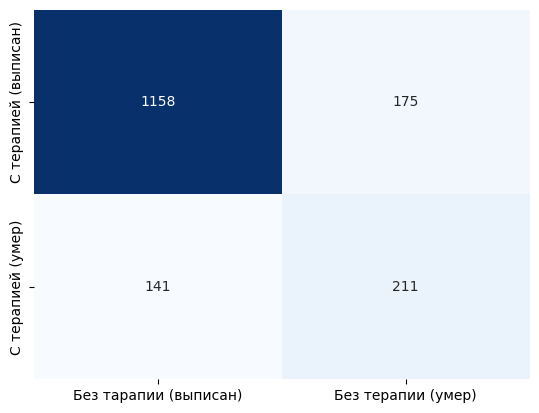

In [427]:
both_died = 0
both_survived=0
only_therapy_survived=0
only_without_therapy_survived=0
for i in range(len(pairs_men)):
    if pairs_men[i][0]['Outcome']=='Выписан' and pairs_men[i][1]['Outcome']=='Выписан':
        both_survived+=1
    elif pairs_men[i][0]['Outcome']=='Выписан' and pairs_men[i][1]['Outcome']=='Умер':
        only_therapy_survived+=1
    elif pairs_men[i][0]['Outcome']=='Умер' and pairs_men[i][1]['Outcome']=='Выписан':
        only_without_therapy_survived+=1
    else:
        both_died+=1

for i in range(len(pairs_women)):
    if pairs_women[i][0]['Outcome']=='Выписан' and pairs_women[i][1]['Outcome']=='Выписан':
        both_survived+=1
    elif pairs_women[i][0]['Outcome']=='Выписан' and pairs_women[i][1]['Outcome']=='Умер':
        only_therapy_survived+=1
    elif pairs_women[i][0]['Outcome']=='Умер' and pairs_women[i][1]['Outcome']=='Выписан':
        only_without_therapy_survived+=1
    else:
        both_died+=1

contingency_table = pd.DataFrame({
    'Без тарапии (выписан)': [both_survived, only_without_therapy_survived],
    'Без терапии (умер)': [only_therapy_survived, both_died]},
    index=['С терапией (выписан)', 'С терапией (умер)']
)

print("Таблица сопряженности:")
print(contingency_table)
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', cbar=False)


Общее количество пациентов: 1685
Выживаемость в группе С терапией: 79.1%
Выживаемость в группе БЕЗ терапии: 77.1%


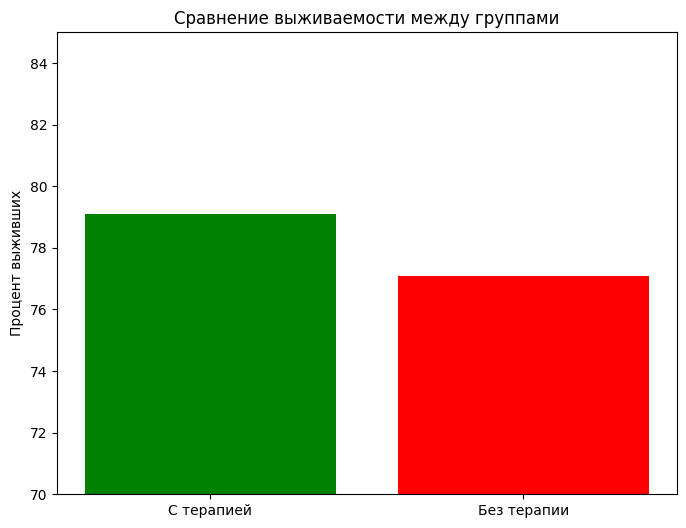

In [433]:


# Расчет процентов
percent_with_drug_survived = (both_survived + only_therapy_survived) / pairs_len * 100
percent_without_drug_survived = (both_survived +  only_without_therapy_survived) / pairs_len * 100

print(f"Общее количество пациентов: {pairs_len}")
print(f"Выживаемость в группе С терапией: {percent_with_drug_survived:.1f}%")
print(f"Выживаемость в группе БЕЗ терапии: {percent_without_drug_survived:.1f}%")

survival_data = pd.DataFrame({
    'Группа': ['С терапией', 'Без терапии'],
    'Выживаемость (%)': [percent_with_drug_survived, percent_without_drug_survived]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(survival_data['Группа'], survival_data['Выживаемость (%)'], color=['green', 'red'])
plt.ylabel('Процент выживших')
plt.title('Сравнение выживаемости между группами')
plt.ylim(70, 85)
plt.show()


In [429]:
from statsmodels.stats.contingency_tables import mcnemar

# Используем только информативные пары (где исходы различаются)
pairs = [[both_survived, only_therapy_survived ],
                     [only_without_therapy_survived, both_died]]

result = mcnemar(pd.DataFrame(pairs))
print(f"McNemar's test p-value: {result.pvalue:.4f}")

McNemar's test p-value: 0.0632


In [430]:
therapy_days = []
no_therapy_days = []

for pair in pairs_men + pairs_women:
    t, n = pair[0], pair[1]
    if t['Outcome'] == 'Выписан' and n['Outcome'] == 'Выписан':
        therapy_days.append(t['Duration'])
        no_therapy_days.append(n['Duration'])

In [431]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mean_therapy = np.mean(therapy_days)
mean_no_therapy = np.mean(no_therapy_days)

std_therapy = np.std(therapy_days, ddof=1)
std_no_therapy = np.std(no_therapy_days, ddof=1)

print(f"С терапией: среднее = {mean_therapy:.2f}, std = {std_therapy:.2f}")
print(f"Без терапии: среднее = {mean_no_therapy:.2f}, std = {std_no_therapy:.2f}")

С терапией: среднее = 15.72, std = 8.27
Без терапии: среднее = 11.87, std = 6.97


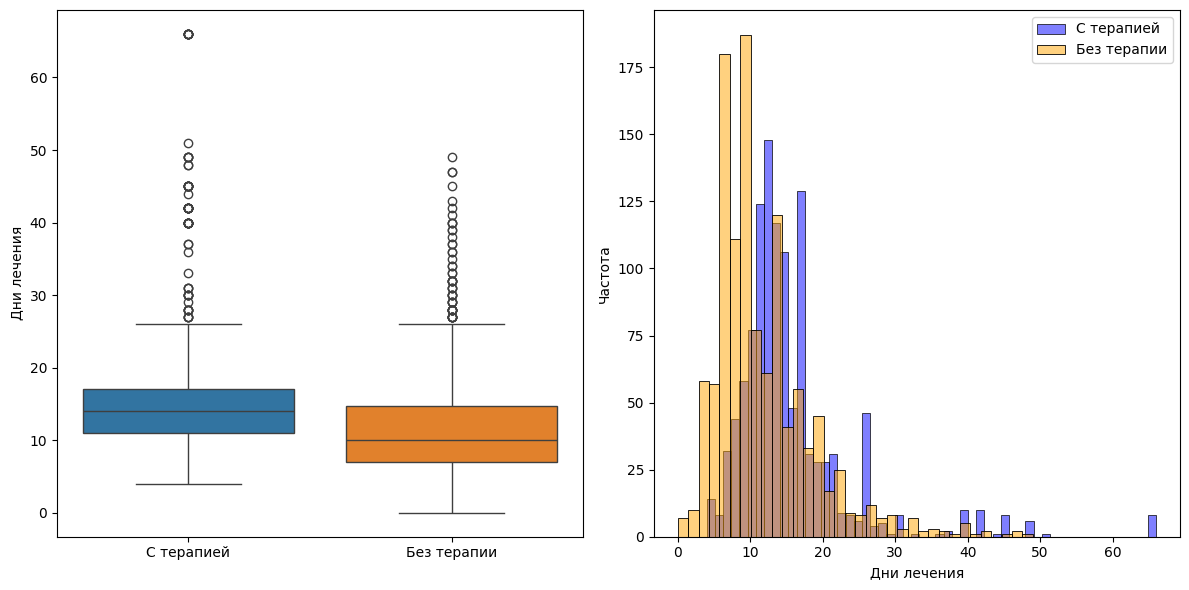

In [432]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=[therapy_days, no_therapy_days])
plt.xticks([0, 1], ['С терапией', 'Без терапии'])
plt.ylabel('Дни лечения')

plt.subplot(1, 2, 2)
sns.histplot(therapy_days, color='blue', alpha=0.5, label='С терапией')
sns.histplot(no_therapy_days, color='orange', alpha=0.5, label='Без терапии')
plt.xlabel('Дни лечения')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()